# Bayesian presidential election forecasting model
Here we'll consider a simple Bayesian model for the 2016 presidential election based on polling data aggregated by FiveThirtyEight.

First, we'll download the polling data in CSV format and do some re-formatting:

In [22]:
import pandas as pd
import numpy as np
import datetime
import pymc3 as pm


LATEST_POLL_DATE = datetime.datetime(2016, 10, 20)
END_POLL_DATE = datetime.datetime(2016, 11, 3)

polls = pd.read_csv('http://projects.fivethirtyeight.com/general-model/president_general_polls_2016.csv',
                    parse_dates=['startdate', 'enddate'])
polls = polls[(polls.enddate > LATEST_POLL_DATE) & (polls.enddate < END_POLL_DATE)]
polls = polls[['state', 'adjpoll_clinton', 'adjpoll_trump']]

# Remove national polls and combine polls for individual congressional districts
polls = polls[polls.state != 'U.S.']
polls.state = polls.state.replace(' CD.*', '', regex=True)

In [23]:
polls

,state,adjpoll_clinton,adjpoll_trump
17,Wisconsin,46.10344,40.97982
22,Virginia,46.39152,41.58078
30,Virginia,45.27399,41.91459
33,North Carolina,47.90348,45.94813
34,Wisconsin,48.22713,38.86464
35,Pennsylvania,45.30896,42.94988
37,North Carolina,44.39882,46.04110
38,Ohio,43.03321,42.67245
40,Missouri,36.55124,49.59908
44,Florida,44.85722,46.49677


We'll also need the number of electoral college votes for each state in order to make predictions about the overall winner:

In [24]:
states = pd.read_csv('https://raw.githubusercontent.com/bnaul/python-seminar/master/DataFiles_and_Notebooks/10_MCMC_and_Symbolic/electoral_votes.csv')
states.head()

,abbr,state,votes
0,AL,Alabama,9
1,AK,Alaska,3
2,AZ,Arizona,11
3,AR,Arkansas,6
4,CA,California,55


In order to make sure we have a decent sample size, we'll count the number of polls per state:

In [25]:
counts_by_state = polls.state.value_counts()
states = states.merge(pd.DataFrame({'poll_count': counts_by_state}), left_on='state', right_index=True)
states.sort_values(by='poll_count').head()

,abbr,state,votes,poll_count
50,WY,Wyoming,3,27
39,RI,Rhode Island,4,27
8,DC,District of Columbia,3,27
11,HI,Hawaii,4,27
36,OK,Oklahoma,7,30


We'll use the following simple model for our polling data: 

- Let $\mu_C$ and $\mu_T$ represent Clinton's and Trump's national levels of support, respectively
- Let $\mu_C^{(i)}$ and $\mu_T^{(i)}$ represent their support within state $i$
- We'll then treat each poll from state $i$ as a sample from a normal distribution centered around each candidate's support there

To more easily link states with their model parameters, we'll add an index column `i`:

In [26]:
states['i'] = states.index
polls = polls.merge(states[['state', 'i']], on='state')
polls.head()

,state,adjpoll_clinton,adjpoll_trump,i
0,Wisconsin,46.10344,40.97982,49
1,Wisconsin,48.22713,38.86464,49
2,Wisconsin,47.83631,42.94844,49
3,Wisconsin,46.73323,39.78602,49
4,Wisconsin,44.61546,39.23007,49


Now we're ready to define our `pymc3` model:

In [27]:
with pm.Model() as model:
    # Prior distributions for national- and state-level support
    mu_C = pm.Normal('mu_C', mu=42., sd=2.)
    mu_C_state = pm.Normal('mu_C_state', mu=mu_C, sd=2., shape=51)
    mu_T = pm.Normal('mu_T', mu=42., sd=2.)
    mu_T_state = pm.Normal('mu_T_state', mu=mu_T, sd=2., shape=51)

    # Select the appropriate state-level variable for each poll
    mu_C_poll = pm.Deterministic('mu_C_poll', mu_C_state[polls.i])
    mu_T_poll = pm.Deterministic('mu_T_poll', mu_T_state[polls.i])
    
    # Gaussian likelihood for polling data
    C_polls = pm.Normal('C_polls', mu=mu_C_poll, sd=5., observed=polls.adjpoll_clinton)
    T_polls = pm.Normal('T_polls', mu=mu_T_poll, sd=5., observed=polls.adjpoll_trump)

Our goal is to model posterior distribution of parameters given observed data:
1. Choose a MCMC sampler (defaults are NUTS/Metropolis-Hastings)
2. Run chain for a while to reduce correlation with starting value ("burn-in")
3. Take every $n$th step as samples from the approximate posterior ("thinning")

In [29]:
N = int(1e4)
burn_in_frac = 0.1
thin_factor = 5

with model:
    step = pm.NUTS()
    trace = pm.sample(N, step=step, njobs=2)
    
burned_in = trace[int(burn_in_frac * N):]
samples = burned_in[::thin_factor]

/Users/jbloom/anaconda3/lib/python3.6/site-packages/pymc3/model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu_T_state, mu_T, mu_C_state, mu_C]
100%|██████████| 10500/10500 [00:54<00:00, 191.94it/s]


We'll use the `chorogrid` tool (https://github.com/Prooffreader/chorogrid) to visualize results using a map of the U.S.:

In [7]:
!pip install -q chorogrid

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import os
import chorogrid as cg


def us_choropleth(state_df, column, fenceposts=None, map_type='map'):
    """Draw a U.S. map color-coded by `state_df[column]`."""
    # Hard-coded FiveThirtyEight color palette
    colors = ['#fc6b5e', '#fd998a', '#fec2b6', '#fee7e2', '#e2edfb', '#b3d4f5', '#7fbaf0', '#33a2e9']
    mybin = cg.Colorbin(state_df[column], colors, proportional=True, decimals=None)
    mybin.set_decimals(2)
    if fenceposts is not None:
        mybin.fenceposts = fenceposts
    mybin.recalc(fenceposts=False)
    colors_by_state = mybin.colors_out
    font_colors_by_state = mybin.complements
    legend_colors = mybin.colors_in
    legend_labels = mybin.labels
    usa_states_file = os.path.join(os.path.dirname(cg.__file__), 'databases', 'usa_states.csv')
    grid = cg.Chorogrid(usa_states_file, state_df.abbr, colors_by_state)
    if map_type == 'map':
        grid.draw_map(spacing_dict={'legend_offset': [-150, -25]})
    elif map_type == 'hex':
        grid.draw_hex(spacing_dict={'legend_offset': [-150, -25]})
    else:
        raise NotImplementedError("Unrecognized map type.")
    grid.done(show=True)

Our estimate of the probability that Clinton/Trump wins a given state is simply the number of realizations in which that candidate's share of the vote is higher:

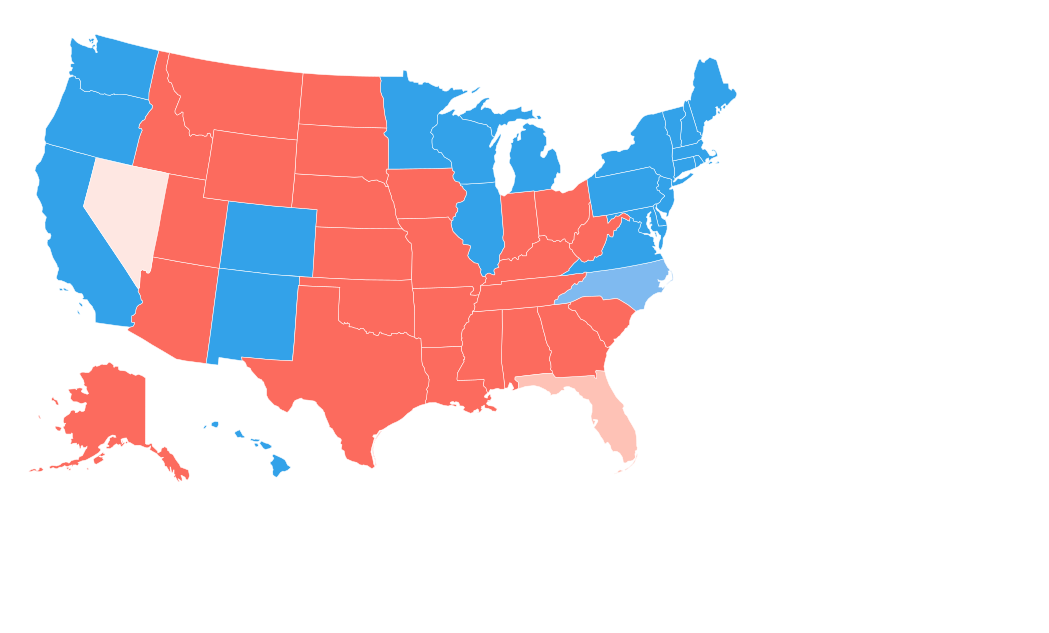

In [31]:
states['prob_clinton'] = (samples['mu_C_state'] > samples['mu_T_state']).mean(axis=0)
us_choropleth(states, 'prob_clinton', map_type='map')

Electoral college: Clinton [323 294 294 ... 323 317 288], Trump [215 244 244 ... 215 221 250]


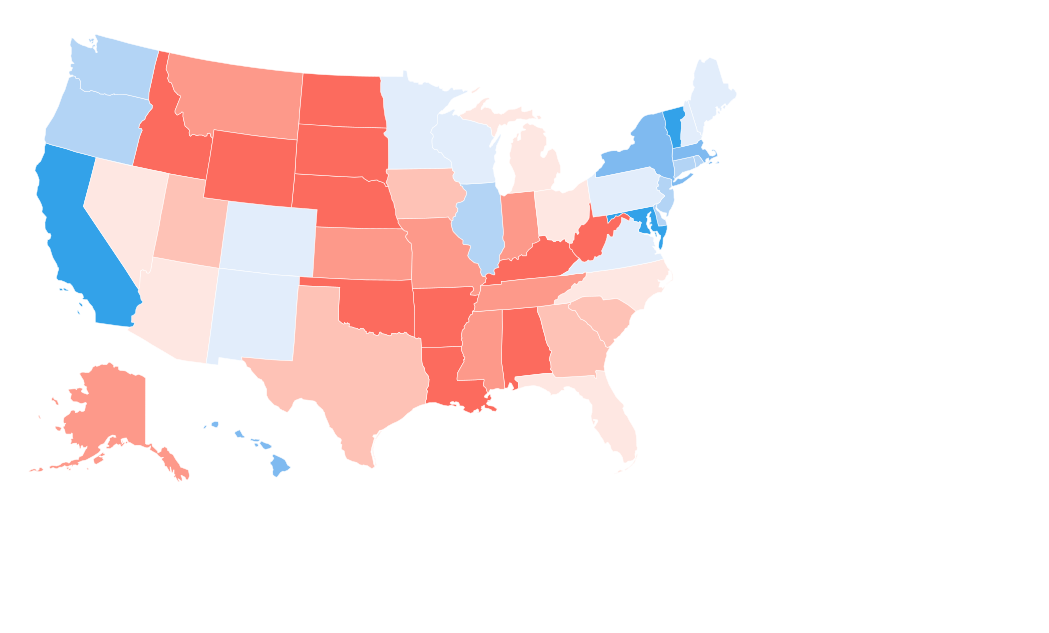

In [17]:
clinton_votes = np.sum(np.atleast_2d(states.votes)
                       * (samples['mu_C_state'] > samples['mu_T_state']), axis=1)
trump_votes = np.sum(np.atleast_2d(states.votes)
                     * (samples['mu_C_state'] < samples['mu_T_state']), axis=1)

j = np.random.randint(len(samples))
states['vote_diff'] = samples['mu_C_state'][j] - samples['mu_T_state'][j]
print("Electoral college: Clinton {}, Trump {}".format(clinton_votes, trump_votes))
clinton_votes = np.sum(states.votes * (states['vote_diff'] > 0))
trump_votes = np.sum(states.votes * (states['vote_diff'] < 0))
us_choropleth(states, 'vote_diff', fenceposts=np.linspace(-20, 20, 8), map_type='map')

The actual map:
<img src="https://www.realclearpolitics.com/incls/ap_results/2016_general/live_map_president.png?1523853836192">

If we only care about who wins the electoral college, then we should calculate the number of votes in each sample and examine that distribution:

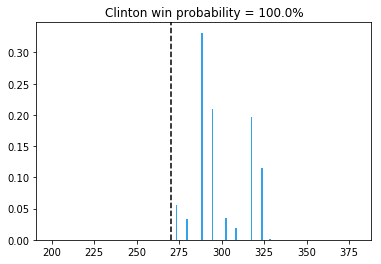

In [34]:
clinton_votes = np.sum(np.atleast_2d(states.votes)
                       * (samples['mu_C_state'] > samples['mu_T_state']), axis=1)
trump_votes = np.sum(np.atleast_2d(states.votes)
                     * (samples['mu_C_state'] < samples['mu_T_state']), axis=1)

n, bins, patches = plt.hist(clinton_votes, bins=np.arange(200, 380), normed=True, color='#33a2e9')
bin_centers = 0.5 * (bins[:-1] + bins[1:])
for c, p in zip(bin_centers, patches):
    if c < 270:
        plt.setp(p, 'facecolor', '#fc6b5e')
plt.axvline(270, color='k', ls='dashed')
plt.title("Clinton win probability = {:2.1f}%".format(100 * (clinton_votes > 270).mean()));

The `forestplot` function from `pmyc3` can show the distribution of the vote for each state:

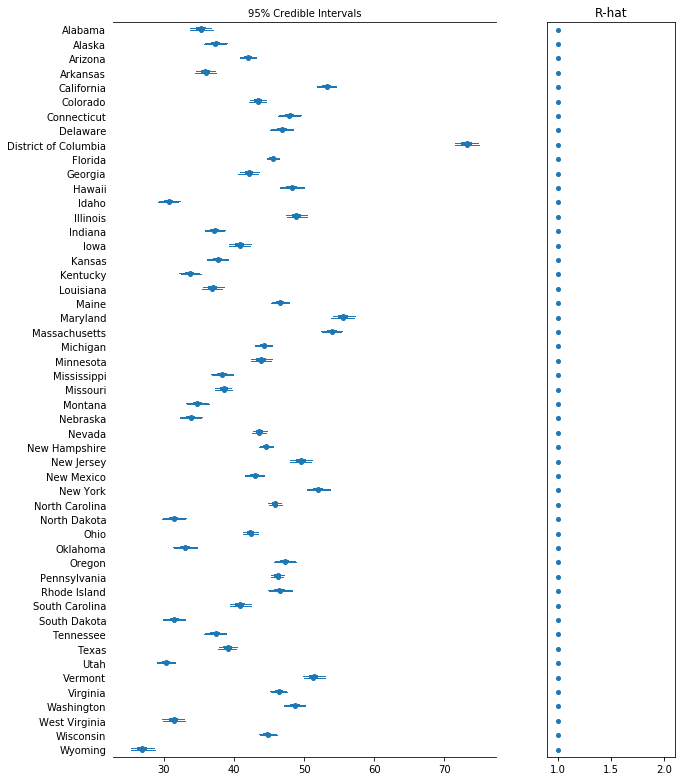

In [33]:
plt.figure(figsize=(12, 12))
pm.forestplot(samples, varnames=['mu_C_state'], ylabels=states.state);